# Interactive exploration
In this part, we can interactively explore the structures found on the pca landscape.
For this, press the {guilabel}`Live Code` button above and run the below cell.

In [1]:
import numpy as np
import nglview as nv
import pandas as pd
import mdtraj as md
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook

def pickle_load(path):
    """Load object from pickle file, given by path"""
    import pickle
    with open(path, "rb") as f:
        object = pickle.load(f)
    return object


def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    """source: https://github.com/gph82/nglview_notebooks"""
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """

    kdtree = cKDTree(pos)
    assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T

    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False

    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index

    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))

    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)

    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")
    

folder = "test_report/assets/22/"
topology = f"{folder}mc_gas.prmtop"
trajectory = f"{folder}ed6dd3148ef9b069_short-traj.netcdf"
dihedral_file = f"{folder}ed6dd3148ef9b069_dihedrals.dat"
dpca_file = f"{folder}ed6dd3148ef9b069_dPCA.dat"
weight_file = f"{folder}ed6dd3148ef9b069_dPCA_weights_MC.dat"

In [2]:
traj = md.load(trajectory, top=topology)
# Plot dihedral PCA
dihedrals = pickle_load(dihedral_file)
dpca = pickle_load(dpca_file)
weights = pickle_load(weight_file)
pca_dihedrals = dpca.transform(dihedrals)

<IPython.core.display.Javascript object>


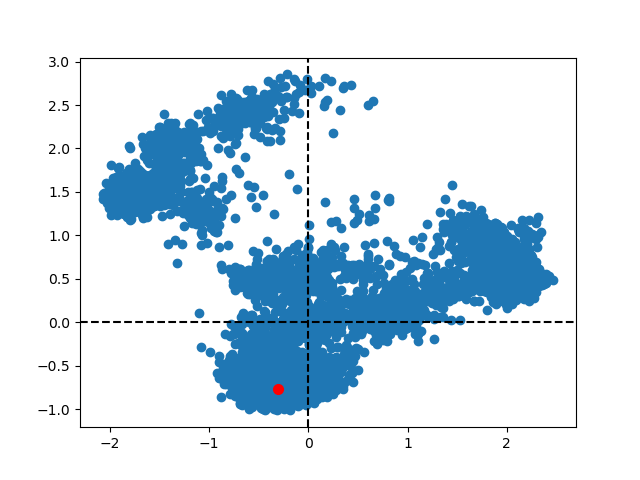

NGLWidget(max_frame=9999)

In [3]:
v = nv.show_mdtraj(traj)
v.clear_representations()
v.add_representation('licorice')
fig, ax = plt.subplots()
link_ngl_wdgt_to_ax_pos(ax, pca_dihedrals, v)
ax = plt.scatter(pca_dihedrals[:,0], pca_dihedrals[:,1])
v